In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Load data
df_A = pd.read_csv(r"C:\Users\priya\Downloads\dfA724.csv")
dfA_filtered = df_A[df_A['Area'] > 0.0005].copy()
df_B = pd.read_csv(r"C:\Users\priya\Downloads\dfB724.csv")
df_C = pd.read_csv(r"C:\Users\priya\Downloads\dfC724.csv")
df_D = pd.read_csv(r"C:\Users\priya\Downloads\dfD724.csv")

dfA_filtered['particle_type'] = 'A'
df_B['particle_type'] = 'B'
df_C['particle_type'] = 'C'
df_D['particle_type'] = 'D'

df_all = pd.concat([dfA_filtered, df_B, df_C, df_D], ignore_index=True)

# Drop unwanted columns
df_all = df_all.drop(columns=['EulerNumber', 'Label', 'PixelCount', 'AverageThickness', 'InscrDisc.Center.X', 'InscrDisc.Center.Y'])
# df_all = df_all.drop(columns=[col for col in df_all.columns if '.X' in col or '.Y' in col])

# Feature engineering
df_all['Perimeter_Area_Ratio'] = df_all['Perimeter'] / df_all['Area']
df_all['Solidity'] = df_all['ConvexArea'] / df_all['Area']
# Features and target
X = df_all.drop(columns=['particle_type'])
y = df_all['particle_type']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [2]:
import sklearn
print("scikit-learn version when loading model:", sklearn.__version__)


scikit-learn version when loading model: 1.6.1


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from mlxtend.feature_selection import ExhaustiveFeatureSelector
import pandas as pd



clf = DecisionTreeClassifier()

efs = ExhaustiveFeatureSelector(clf,
                                min_features=1,
                                max_features=X.shape[1],
                                scoring='accuracy',  # or F1, recall, etc.
                                print_progress=True,
                                cv=5)

efs = efs.fit(X.values, y.values)

print('Best score:', efs.best_score_)
print('Best subset (indices):', efs.best_idx_)
print('Best subset (names):', [X.columns[i] for i in efs.best_idx_])


## Most basic random forest tree classifier

In [2]:
# Train a basic Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.98      0.92      0.95       179
           B       0.86      0.86      0.86       165
           C       0.78      0.87      0.82        76
           D       0.90      1.00      0.95         9

    accuracy                           0.89       429
   macro avg       0.88      0.91      0.89       429
weighted avg       0.89      0.89      0.89       429

[[165  14   0   0]
 [  4 142  19   0]
 [  0   9  66   1]
 [  0   0   0   9]]


## Hyperparameter Tuned Random Forest Tree Classifier (with class weight = balanced)

In [3]:
clf = RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           A       0.98      0.92      0.95       179
           B       0.87      0.88      0.87       165
           C       0.80      0.89      0.84        76
           D       0.90      1.00      0.95         9

    accuracy                           0.90       429
   macro avg       0.89      0.92      0.90       429
weighted avg       0.90      0.90      0.90       429

[[164  15   0   0]
 [  3 145  17   0]
 [  0   7  68   1]
 [  0   0   0   9]]


## Hyperparameter Tuned Random Forest Tree Classifier (without class weight = balanced)

In [4]:

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)
clf.fit(X_train, y_train)

#Predict
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.98      0.92      0.95       179
           B       0.87      0.88      0.87       165
           C       0.80      0.89      0.84        76
           D       0.90      1.00      0.95         9

    accuracy                           0.90       429
   macro avg       0.89      0.92      0.90       429
weighted avg       0.90      0.90      0.90       429

[[164  15   0   0]
 [  3 145  17   0]
 [  0   7  68   1]
 [  0   0   0   9]]


In [5]:

from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5, scoring='f1_macro')
grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1_macro')

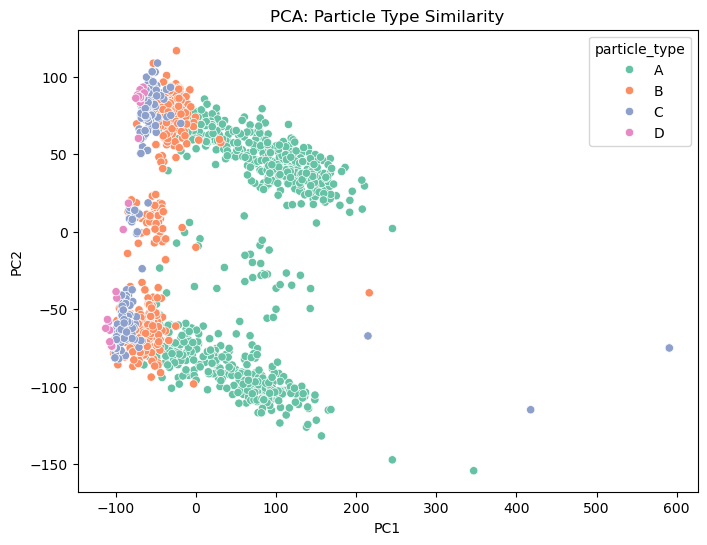

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X is your feature set and y is the class labels
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_viz = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_viz['particle_type'] = y.values if isinstance(y, pd.Series) else y

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_viz, x='PC1', y='PC2', hue='particle_type', palette='Set2')
plt.title('PCA: Particle Type Similarity')
plt.show()


              precision    recall  f1-score   support

           A       0.98      0.93      0.95       224
           B       0.86      0.85      0.85       165
           C       0.77      0.89      0.83        75
           D       1.00      1.00      1.00         9

    accuracy                           0.90       473
   macro avg       0.90      0.92      0.91       473
weighted avg       0.90      0.90      0.90       473



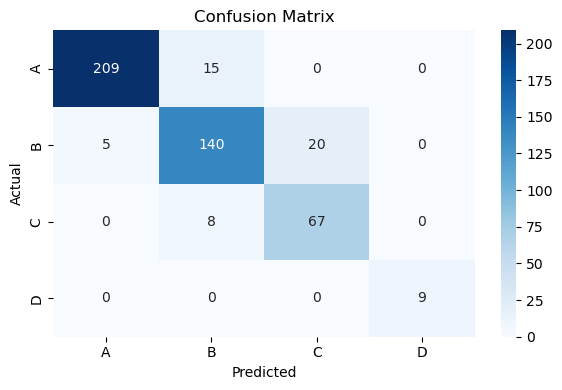

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Predict and evaluate
y_pred = clf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Create a labeled confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

# Plot with seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


                 Feature  Importance
0                   Area    0.134544
12       Ellipse.Radius2    0.114972
28  Perimeter_Area_Ratio    0.103794
22            OBox.Width    0.103505
26      InscrDisc.Radius    0.097971
15            ConvexArea    0.095438
1              Perimeter    0.074053
24      GeodesicDiameter    0.045655
17          MaxFeretDiam    0.044699
11       Ellipse.Radius1    0.037118
21           OBox.Length    0.033645
27    GeodesicElongation    0.016415
16             Convexity    0.014262
29              Solidity    0.008850
2            Circularity    0.007945
19         OBox.Center.X    0.005461
23      OBox.Orientation    0.005277
7             Centroid.X    0.004953
18     MaxFeretDiamAngle    0.004917
14         Ellipse.Elong    0.004827
9       Ellipse.Center.X    0.004581
4              Box.X.Max    0.004529
3              Box.X.Min    0.004514
6              Box.Y.Max    0.004402
25            Tortuosity    0.004363
13   Ellipse.Orientation    0.004078
5

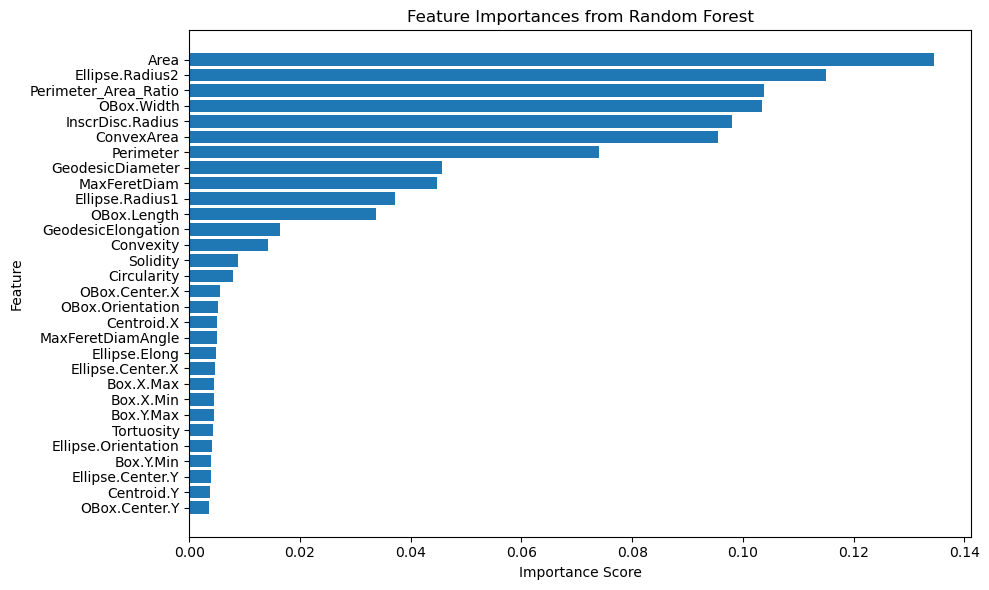

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
importances = clf.feature_importances_

# Get feature names
feature_names = X.columns

# Create a DataFrame for better display
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the top features
print(importance_df)

# Optional: Plot the importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [9]:
from sklearn.tree import export_text

for i, tree in enumerate(clf.estimators_):
    print(f"\nTree {i} rules:\n")
    print(export_text(tree, feature_names=feature_names))



Tree 0 rules:

|--- MaxFeretDiam <= 0.62
|   |--- Perimeter <= 0.47
|   |   |--- GeodesicDiameter <= 0.02
|   |   |   |--- class: 2.0
|   |   |--- GeodesicDiameter >  0.02
|   |   |   |--- Ellipse.Radius2 <= 0.05
|   |   |   |   |--- Area <= 0.00
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- Area >  0.00
|   |   |   |   |   |--- Ellipse.Center.X <= 9.01
|   |   |   |   |   |   |--- OBox.Center.X <= 5.27
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- OBox.Center.X >  5.27
|   |   |   |   |   |   |   |--- MaxFeretDiamAngle <= 165.68
|   |   |   |   |   |   |   |   |--- Convexity <= 0.87
|   |   |   |   |   |   |   |   |   |--- Box.X.Max <= 5.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |   |--- Box.X.Max >  5.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- Convexity >  0.87
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- 

In [10]:
from sklearn.tree import export_text

tree_rules = export_text(clf.estimators_[0], feature_names=list(X.columns))
print(tree_rules)


|--- MaxFeretDiam <= 0.62
|   |--- Perimeter <= 0.47
|   |   |--- GeodesicDiameter <= 0.02
|   |   |   |--- class: 2.0
|   |   |--- GeodesicDiameter >  0.02
|   |   |   |--- Ellipse.Radius2 <= 0.05
|   |   |   |   |--- Area <= 0.00
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- Area >  0.00
|   |   |   |   |   |--- Ellipse.Center.X <= 9.01
|   |   |   |   |   |   |--- OBox.Center.X <= 5.27
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- OBox.Center.X >  5.27
|   |   |   |   |   |   |   |--- MaxFeretDiamAngle <= 165.68
|   |   |   |   |   |   |   |   |--- Convexity <= 0.87
|   |   |   |   |   |   |   |   |   |--- Box.X.Max <= 5.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |   |--- Box.X.Max >  5.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- Convexity >  0.87
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- MaxFeretDiamAngl

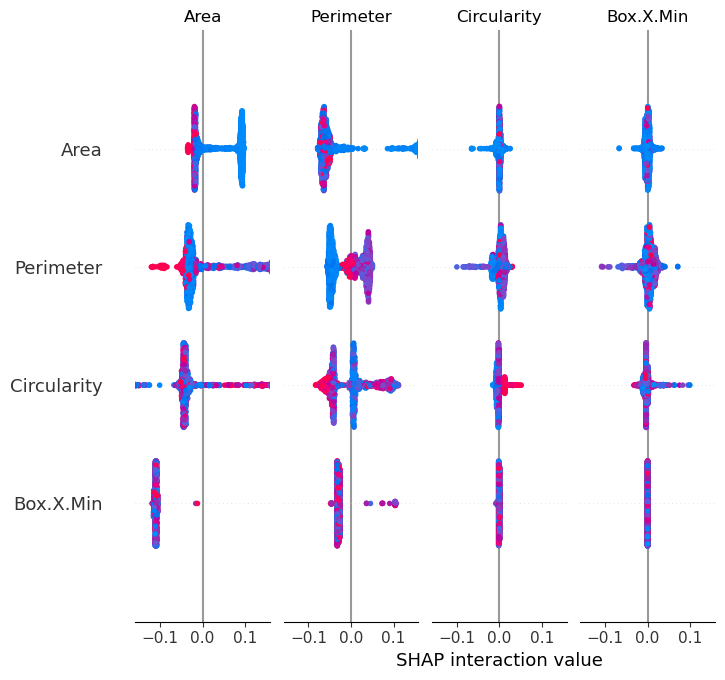

In [11]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)


## Example Draft

In [12]:
import numpy as np
import pandas as pd

# ————————————————
# 1) Load & clean
# ————————————————
df = pd.read_csv(r"C:\Users\priya\Downloads\Scale3_MorphoLibJ.csv")

# drop columns you don't need
drop_cols = ['Label', 'PixelCount', 'EulerNumber']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# ————————————————
# 2) Recompute derived features
# ————————————————
if 'Perimeter_Area_Ratio' not in df:
    df['Perimeter_Area_Ratio'] = df['Perimeter'] / df['Area']

if 'Solidity' not in df:
    df['Solidity'] = df['ConvexArea'] / df['Area']

# ————————————————
# 3) Align to training features
# ————————————————
# X.columns is your list of features used at train time
trained_features = list(X.columns)
df_aligned = df[trained_features].copy()

# ————————————————
# 4) Predict & decode
# ————————————————
y_pred = clf.predict(df_aligned)
y_labels = le.inverse_transform(y_pred)

# attach predictions to your DataFrame
df_aligned['predicted_label'] = y_labels

# ————————————————
# 5) Compute average numeric class
# ————————————————
mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4}
df_aligned['predicted_numeric'] = df_aligned['predicted_label'].map(mapping)

avg_class = df_aligned['predicted_numeric'].mean()
print(f"🔢 Average predicted class value: {avg_class:.2f}")

# ————————————————
# 6) Compute relative area per class
# ————————————————
total_area = df_aligned['Area'].sum()
area_by_class = (
    df_aligned
      .groupby('predicted_label')['Area']
      .sum()
      .divide(total_area)
)

print("\n📊 Relative area by predicted class:")
print(area_by_class)

# 7) Particle count per class
counts = df_aligned['predicted_label'] \
            .value_counts() \
            .reindex(['A','B','C','D'], fill_value=0)  # ensure all classes show up

# add total
counts['Total'] = counts.sum()
print("\n📊 Particle Counts by predicted class:")
print(counts)

# mean area, histogram area, mean diameter, mean solidity

🔢 Average predicted class value: 2.09

📊 Relative area by predicted class:
predicted_label
A    0.236650
B    0.576656
C    0.186694
Name: Area, dtype: float64

📊 Particle Counts by predicted class:
predicted_label
A        1171
B         371
C        1450
D           0
Total    2992
Name: count, dtype: int64


In [13]:
import joblib

# Save classifier
joblib.dump(clf, 'my_classifier.pkl')

# Save label encoder (used for inverse_transform)
joblib.dump(le, 'label_encoder.pkl')

# Save list of features used during training
trained_features = list(X.columns)
joblib.dump(trained_features, 'trained_features.pkl')


['trained_features.pkl']